In [42]:
import get_db_data as gdd
import analyze_signal as anaz
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
reload(gdd);
reload(anaz);
from sqlalchemy.engine.result import RowProxy
from numpy.linalg import norm

In [2]:
con = gdd.get_db_data()

In [3]:
par = con.get_participants()

In [4]:
par[:10]

[(1001, 101),
 (1001, 102),
 (1001, 103),
 (1003, 108),
 (1003, 109),
 (1004, 110),
 (1004, 111),
 (1004, 112),
 (1005, 113),
 (1005, 114)]

In [5]:
gr = con.con.execute("""
SELECT group_id
FROM participants
GROUP BY group_id
Having count(1)=3""").fetchall()

In [43]:
def get_signal_triplets(groups, con):
    cur =0
    par = con.get_participants()
    for group_id in groups:
        if type(group_id) == RowProxy:
            group_id = group_id[0] #un-tuple
        while par[cur][0] < group_id:
            cur += 1
        group_signals = list(con.get_signal_by_series_type_and_interp_type([par[cur+i][1] for i in range(3)],2,4))
        cur +=2
        yield group_signals
    

In [44]:
gr[0][0]

1001

In [45]:
st = get_signal_triplets(gr,con)

In [46]:
gs=next(st)

In [47]:
gs

[(101,
  array([[  2.     ,   0.96924],
         [  2.25   ,   0.9182 ],
         [  2.5    ,   0.83614],
         ...,
         [236.     ,   0.84912],
         [236.25   ,   0.83258],
         [236.5    ,   0.81765]])),
 (102,
  array([[  2.     ,   0.66947],
         [  2.25   ,   0.66565],
         [  2.5    ,   0.65468],
         ...,
         [236.     ,   0.79881],
         [236.25   ,   0.7988 ],
         [236.5    ,   0.79717]])),
 (103,
  array([[  2.     ,   0.6121 ],
         [  2.25   ,   0.59968],
         [  2.5    ,   0.59083],
         ...,
         [236.     ,   0.61297],
         [236.25   ,   0.62078],
         [236.5    ,   0.62891]]))]

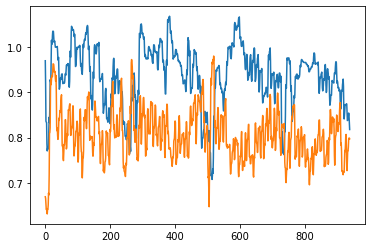

In [11]:
s1 = gs[0][1][:,1]
s2 = gs[1][1][:,1]
plt.plot(s1)
plt.plot(s2)

In [12]:
# verify that the amplitude of fft computed with anaz is 1

#s1n = (s1-s1.mean())/s1.std()
#s2n = (s2-s2.mean())/s2.std()
p1 = anaz.psd(s1,0.25)
p2 = anaz.psd(s2,0.25)
#p1c = anaz.psd(s1n,0.25)

In [13]:
norm(p1.psd),norm(s1)

(0.9999999999999999, 28.752552521016288)

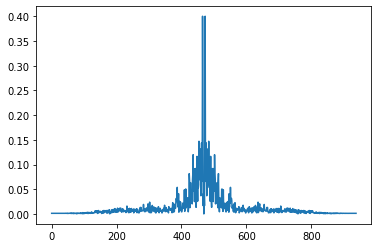

In [14]:
plt.plot(p1.psd)

In [64]:
n=len(p1.raw_fft)
n2=int(n/2)
print(
    np.real(np.vdot(p1.raw_fft,p2.raw_fft)),
    np.corrcoef(p1.normed_signal,p2.normed_signal)[0,1],
    np.corrcoef(s1,s2)[1,0],
    sum(p1.raw_fft*np.conj(p2.raw_fft)),
    np.real(sum(p1.raw_fft[n2:]*np.conj(p2.raw_fft[n2:])))*2,
    np.real(np.cumsum(p1.raw_fft[n2:]*np.conj(p2.raw_fft[n2:]))[-1])*2
)

0.009439013620339352 0.009439013620339193 0.009439013620339358 (0.009439013620339361+4.905080529995029e-18j) 0.009439013620339354 0.009439013620339354


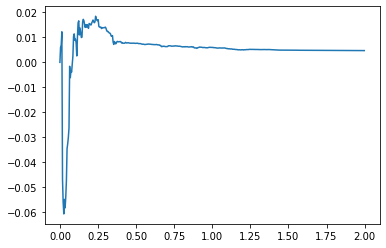

In [26]:
plt.plot(p1.freq[n2:],np.real(np.cumsum(p1.raw_fft[n2:]*np.conj(p2.raw_fft[n2:]))))

In [28]:
n,n2

(939, 469)

In [161]:
def explore_corr(triplets, detrend_signal=False):
    for trip in triplets:
        pars = [x[0] for x in trip]
        signals = [x[1][:,1] for x in trip]
        if detrend:
            print("de-trending")
            signals = [detrend(x) for x in signals]
        trans = [anaz.psd(s,0.25) for s in signals]
        trans = trans + [trans[0]]
        n = len(signals[0])//2
        corrcoefs = [
            np.round(np.real(np.vdot(
                trans[i].raw_fft,
                trans[i+1].raw_fft
            )),5) for i in range(3)]
        cumcorr = [
            np.real(np.cumsum(
                trans[i].raw_fft[n:]*np.conj(trans[i+1].raw_fft[n:])
            )) for i in range(3)]
        print(pars)
        print(corrcoefs)
        ax = []
        plt.figure(figsize=(8,12))
        ax.append(plt.subplot(3,1,1))
        plt.plot(trans[0].freq[n:], cumcorr[0],'.-')
        ax.append(plt.subplot(3,1,2))
        plt.plot(trans[0].freq[n:], cumcorr[1],'.-')
        ax.append(plt.subplot(3,1,3))
        plt.plot(trans[0].freq[n:], cumcorr[2],'.-')
        yield signals,trans,ax

        

In [162]:
#st = get_signal_triplets(gr,con)
a = explore_corr(st,True)

de-trending
[119, 120, 121]
[0.42153, 0.55329, 0.25267]


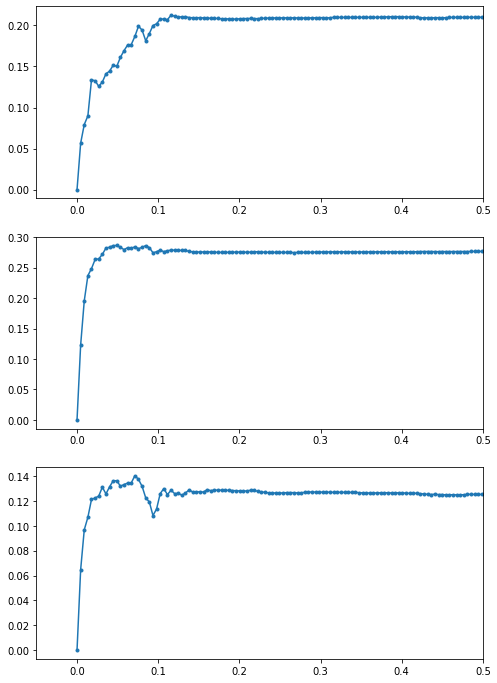

In [166]:
s,t,ax=next(a)
[a.set_xlim(-0.05,0.5) for a in ax];

In [76]:
y1[-1]

0.004719506810169677

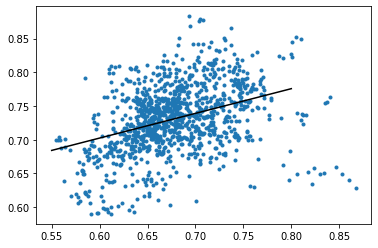

In [130]:
lr = LinearRegression()
lr.fit(s[0].reshape(-1,1),s[1].reshape(-1,1))

plt.plot(s[0],s[1],'.')
x_fit = np.array([0.55, 0.8])
y_fit = lr.coef_*x_fit + lr.intercept_
plt.plot(x_fit,y_fit.squeeze(),'k-')

In [118]:
from sklearn.linear_model import LinearRegression 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [125]:
lr.coef_

array([[0.36637083]])

In [126]:
lr.intercept_

array([0.4826271])

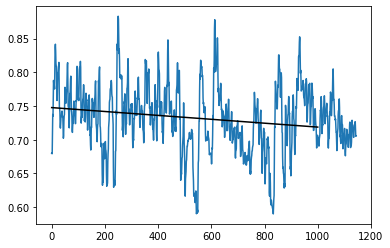

In [132]:
plt.plot(s[1])
lr = LinearRegression()
lr.fit(np.arange(len(s[1])).reshape(-1,1),s[1].reshape(-1,1))
x_fit = np.array([0,1000])
y_fit = lr.coef_*x_fit+lr.intercept_
plt.plot(x_fit,y_fit.squeeze(),'k-')

(1145, 1) (1145,)


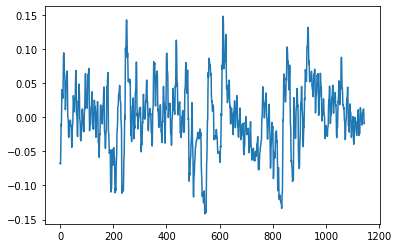

In [148]:
x = np.arange(len(s[1])).reshape(-1,1)
y_hat = lr.predict(x)
print(y_hat.shape,(s[1]-y_hat.squeeze()).shape)
res = s[1]-y_hat.squeeze()
plt.plot(res)

In [151]:
def detrend(signal):
    x = np.arange(len(signal)).reshape(-1,1)
    y_hat = LinearRegression().fit(x,signal.reshape(-1,1)).predict(x)
    return signal-y_hat.squeeze()

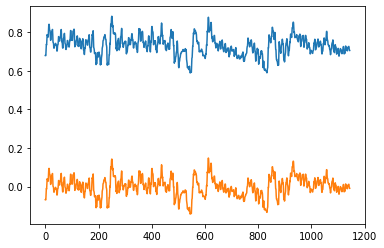

In [154]:
plt.plot(s[1])
plt.plot(detrend(s[1]))